In [46]:
"""
1-D, depth-averaged, linear shallow-water model for lagoon setup + seiching.

State:
  eta(x,t): free-surface elevation (m) at cell centers
  u(x,t):   depth-averaged along-lagoon velocity (m/s) at cell faces (staggered grid)

Equations (linear SWE with linear bottom friction and wind stress):
  u_t + g * eta_x + r*u = tau_w(t) / (rho_w * h)
  eta_t + h * u_x = 0

Notes
- Closed ends (default): no-normal-flow => u=0 at x=0 and x=L, so free seiche modes exist.
- Optional boundary water-level forcing: impose eta at x=0 and x=L (Dirichlet) to include “along-lagoon
  water levels” (e.g., tide or remote setdown). See `eta_left`, `eta_right`.

Two wind scenarios are created:
  A) steady wind long enough to reach quasi-steady setup, then drop to zero (free seiche rings down)
  B) same steady wind, then rapid reversal (wind + seiche)

Requires: numpy, matplotlib
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# -----------------------------
# Physical + numerical settings
# -----------------------------
g       = 9.81          # m/s^2
rho_w   = 1025.0        # kg/m^3 (water)
rho_air = 1.225         # kg/m^3 (air)
Cd_air  = 1.3e-3        # bulk drag coefficient (order 1e-3)

L = 50_000.0            # lagoon length (m)
h = 2.0                 # uniform depth (m)

N  = 400                # number of eta cells
dx = L / N

c  = np.sqrt(g*h)       # wave speed
CFL = 0.8
dt  = CFL * dx / c      # time step (s)

# Linear bottom friction term r*u (1/s). (Choose small; larger damps faster.)
r_fric = 1.0 / (2*3600) # ~ 6-hour e-folding for velocity

# Time controls
t_spinup = 6 * 3600.0  # steady wind duration (s): long enough to build setup
t_tail   = 18 * 3600.0  # additional duration after change (s)
T        = t_spinup + t_tail
t        = np.arange(0.0, T + dt, dt)
nt       = t.size

# Grids
x_eta = (np.arange(N) + 0.5) * dx      # eta at cell centers (N)
x_u   = np.arange(N+1) * dx            # u at faces (N+1)

# -----------------------------
# Forcing builders
# -----------------------------
def wind_to_tau(U10_mps):
    """Quadratic wind stress (Pa) from 10-m wind speed (m/s), preserving sign."""
    return rho_air * Cd_air * U10_mps * np.abs(U10_mps)

def make_wind_series_case_A(t, U0=15.0, t_spinup=18*3600.0):
    """Steady wind then drop to zero."""
    U = np.zeros_like(t)
    U[t <= t_spinup] = U0
    return U

def make_wind_series_case_B(t, U0=15.0, t_spinup=18*3600.0, t_ramp=10*60.0):
    """
    Steady wind then rapid reversal to -U0 over a short ramp time.
    Ramp avoids a strict discontinuity (numerically nicer, still 'rapid').
    """
    U = np.zeros_like(t)
    U[t <= t_spinup] = U0
    # ramp from +U0 to -U0 over [t_spinup, t_spinup + t_ramp]
    i0 = np.searchsorted(t, t_spinup)
    i1 = np.searchsorted(t, t_spinup + t_ramp)
    if i1 > i0:
        U[i0:i1] = np.linspace(U0, -U0, i1 - i0, endpoint=False)
    U[i1:] = -U0
    return U

# Optional boundary eta forcing (set to None to disable)
def make_boundary_eta(t):
    """
    Example: no boundary forcing (zeros).
    Replace with real time series if desired.
    """
    eta_left  = np.zeros_like(t)
    eta_right = np.zeros_like(t)
    return eta_left, eta_right

# -----------------------------
# Model integrator
# -----------------------------
def run_lagoon_model(
    t, dx, h, g, r_fric,
    U10,                    # wind speed time series (m/s), length nt
    closed_ends=True,       # True: u=0 at both ends; False: allow open ends with eta BC
    eta_left=None,          # optional Dirichlet eta at x=0 (m)
    eta_right=None,         # optional Dirichlet eta at x=L (m)
    store_every=5           # store every kth step to reduce memory
):
    """
    Forward-backward staggered scheme:
      u^{n+1}   = u^n - dt*g*(d eta/dx)^n - dt*r*u^n + dt*(tau_w/(rho_w*h))^n
      eta^{n+1} = eta^n - dt*h*(d u/dx)^{n+1}
    """
    nt = len(t)
    dt = t[1] - t[0]

    # State
    eta = np.zeros(N)        # initial condition: flat
    u   = np.zeros(N+1)

    # Storage
    keep = np.arange(0, nt, store_every)
    eta_hist = np.zeros((keep.size, N), dtype=float)
    U10_hist = np.zeros((keep.size), dtype=float)
    u_hist   = np.zeros((keep.size, N+1), dtype=float)
    t_keep   = t[keep].copy()

    # Precompute wind acceleration term a_w(t) = tau/(rho_w*h)
    tau = wind_to_tau(U10)                 # Pa
    a_w = tau / (rho_w * h)                # m/s^2 (uniform along lagoon)

    kstore = 0

    for n in range(nt):
        # Optionally impose boundary eta (Dirichlet) at current time step
        if (not closed_ends) and (eta_left is not None) and (eta_right is not None):
            eta[0]  = eta_left[n]
            eta[-1] = eta_right[n]

        # ---------
        # Update u
        # ---------
        # eta gradient at faces i=1..N-1:
        #   (eta[i] - eta[i-1]) / dx aligned with u[i]
        deta_dx = np.zeros_like(u)
        deta_dx[1:N] = (eta[1:] - eta[:-1]) / dx

        u = u - dt * (g * deta_dx + r_fric * u) + dt * a_w[n]

        # Closed ends: enforce no-flow at both ends
        if closed_ends:
            u[0]  = 0.0
            u[-1] = 0.0
        else:
            # For open ends with prescribed eta, you may prefer radiation BCs;
            # here we simply leave u unconstrained except where numerics need it.
            pass

        # -----------
        # Update eta
        # -----------
        du_dx = (u[1:] - u[:-1]) / dx       # defined at eta cells
        eta = eta - dt * h * du_dx

        # Re-impose Dirichlet eta after update if using boundary eta forcing
        if (not closed_ends) and (eta_left is not None) and (eta_right is not None):
            eta[0]  = eta_left[n]
            eta[-1] = eta_right[n]

        # Store
        if (n % store_every) == 0:
            eta_hist[kstore, :] = eta
            u_hist[kstore, :]   = u
            U10_hist[kstore] = U10[n]
            kstore += 1

    return t_keep, eta_hist, u_hist, U10_hist

In [47]:
# -----------------------------
# Build forcings and run cases
# -----------------------------
U0 = 15.0  # m/s
t_seiche = 2*L/(np.sqrt(g*h) )
print('Resonant period = ', t_seiche/3600, 'hours.')

U_A = make_wind_series_case_A(t, U0=U0, t_spinup=t_spinup)
U_B = make_wind_series_case_B(t, U0=U0, t_spinup=t_spinup, t_ramp=10*60)

etaL, etaR = make_boundary_eta(t)  # replace with real along-lagoon WL if desired

# Recommended for pure seiche demonstration: closed ends, no boundary eta forcing
tA, etaA, uA, U10A = run_lagoon_model(
    t=t, dx=dx, h=h, g=g, r_fric=r_fric,
    U10=U_A,
    closed_ends=True,
    eta_left=None, eta_right=None,
    store_every=5
)

tB, etaB, uB, U10B = run_lagoon_model(
    t=t, dx=dx, h=h, g=g, r_fric=r_fric,
    U10=U_B,
    closed_ends=True,
    eta_left=None, eta_right=None,
    store_every=5
)

Resonant period =  6.271161680357373 hours.


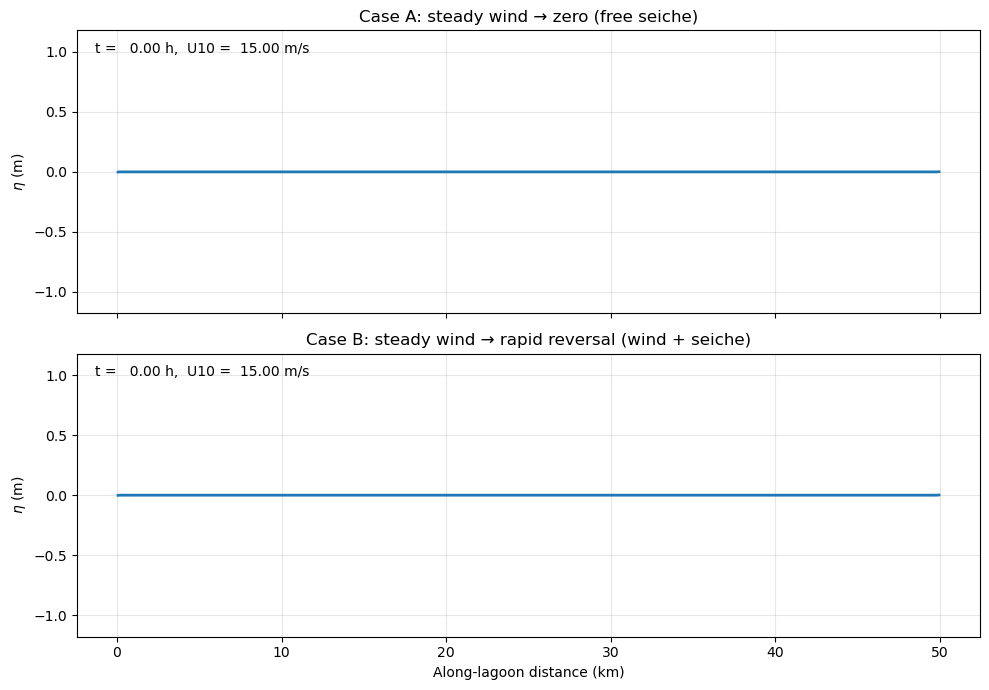

In [ ]:
# -----------------------------
# Animation (side-by-side)
# -----------------------------
# Plot limits from both runs
eta_min = min(np.nanmin(etaA), np.nanmin(etaB))
eta_max = max(np.nanmax(etaA), np.nanmax(etaB))
pad = 0.05 * max(1e-6, (eta_max - eta_min))
eta_min -= pad
eta_max += pad

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
ax1, ax2 = axes

lineA, = ax1.plot(x_eta/1000, etaA[0], lw=2)
lineB, = ax2.plot(x_eta/1000, etaB[0], lw=2)

ax1.set_ylabel(r'$\eta$ (m)')
ax2.set_ylabel(r'$\eta$ (m)')
ax2.set_xlabel('Along-lagoon distance (km)')

ax1.set_title('Case A: steady wind → zero (free seiche)')
ax2.set_title('Case B: steady wind → rapid reversal (wind + seiche)')

for ax in axes:
    ax.set_ylim(eta_min, eta_max)
    ax.grid(True, alpha=0.3)

# time annotations
txtA = ax1.text(0.02, 0.92, '', transform=ax1.transAxes)
txtB = ax2.text(0.02, 0.92, '', transform=ax2.transAxes)

# Also show wind forcing in titles (simple indicator)
def format_time_hours(seconds):
    return seconds / 3600.0

def animate(k):
    # k indexes stored frames
    lineA.set_ydata(etaA[k])
    lineB.set_ydata(etaB[k])

    th = format_time_hours(tA[k])
    txtA.set_text(f"t = {th:6.2f} h,  U10 = {np.interp(tA[k], t, U_A):6.2f} m/s")
    txtB.set_text(f"t = {th:6.2f} h,  U10 = {np.interp(tB[k], t, U_B):6.2f} m/s")
    return lineA, lineB, txtA, txtB

interval_ms = 33  # ~30 fps
anim = FuncAnimation(fig, animate, frames=len(tA), interval=interval_ms, blit=True)

plt.tight_layout()
plt.show()

# ------------------------------------
# (Optional) quick diagnostics / plots
# ------------------------------------
# Example: setup slope at end of spinup (Case A)
# idx_spin = np.argmin(np.abs(tA - t_spinup))
# plt.figure(figsize=(10,4))
# plt.plot(x_eta/1000, etaA[idx_spin])
# plt.xlabel('Along-lagoon distance (km)')
# plt.ylabel(r'$\eta$ (m)')
# plt.title('Case A: eta at end of steady-wind spinup')
# plt.grid(True, alpha=0.3)
# plt.show()

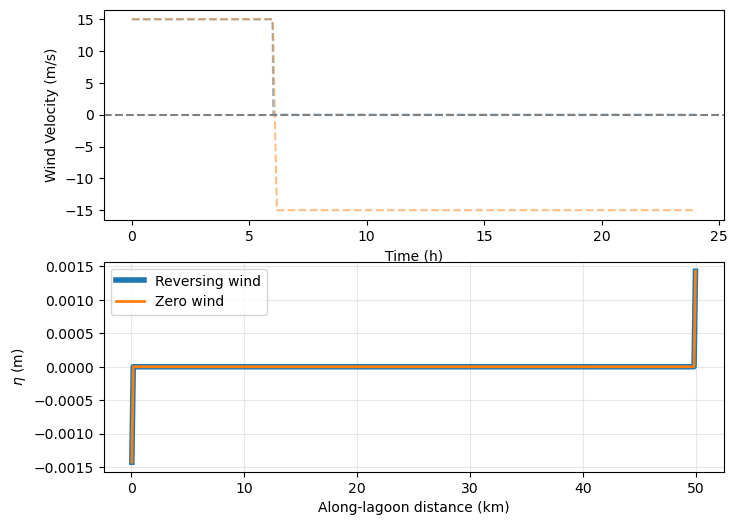

In [49]:
# ------------------------------------
# (Optional) quick diagnostics / plots
# ------------------------------------
# Example: setup slope at end of spinup (Case A)
idx_spin = np.argmin(np.abs(tA - t_seiche/5))
idx = int( 0.*idx_spin )

fig, axs = plt.subplots(2,1,figsize=(8,6))
axs[0].plot(tA/3600, U10A, '--', c='tab:blue', alpha=.5)
axs[0].plot(tA[:idx]/3600,U10A[:idx],'-',c="tab:blue", linewidth=4)
axs[0].plot(tB/3600, U10B, '--',c='tab:orange', alpha=.5)
axs[0].plot(tB[:idx]/3600,U10B[:idx],'-',c="tab:orange", linewidth=2)
axs[0].axhline(y=0, color='gray', linestyle='--')
axs[0].set_xlabel('Time (h)')
axs[0].set_ylabel('Wind Velocity (m/s)')

axs[1].plot(x_eta/1000, etaB[idx], '-', linewidth=4, label='Reversing wind')
axs[1].plot(x_eta/1000, etaA[idx], '-', linewidth=2, label='Zero wind')
axs[1].set_xlabel('Along-lagoon distance (km)')
axs[1].set_ylabel(r'$\eta$ (m)')
#plt.title('Eta near end of steady-wind spinup')
axs[1].grid(True, alpha=0.3)
axs[1].legend()
plt.show()

In [32]:
print(f"Time: {t[idx]/3600:2.2f} h")

Time: 1.25 h


In [4]:
import os
import re
import imageio.v2 as imageio

frames_dir = r"C:\temp\lagoon_frames"      # same as outdir above
prefix = "frame"
img_ext = "png"

out_mp4 = r"C:\temp\lagoon_animation.mp4"  # change as needed
fps = 30                                   # 10–30 typical

# Collect frames in numeric order
pat = re.compile(rf"^{re.escape(prefix)}_(\d+)\.{re.escape(img_ext)}$", re.IGNORECASE)
files = []
for fn in os.listdir(frames_dir):
    m = pat.match(fn)
    if m:
        files.append((int(m.group(1)), os.path.join(frames_dir, fn)))
files.sort(key=lambda x: x[0])
frame_paths = [p for _, p in files]

assert len(frame_paths) > 0, "No frames found. Check frames_dir/prefix/img_ext."

# Write MP4 (requires ffmpeg available to imageio)
with imageio.get_writer(out_mp4, fps=fps, codec="libx264", quality=8) as w:
    for p in frame_paths:
        w.append_data(imageio.imread(p))

print(f"Wrote: {out_mp4}")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1482, 1034) to (1488, 1040) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Wrote: C:\temp\lagoon_animation.mp4
